In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# make PTA and likelihood objects
pta = PTA(Np=5,
          Tspan_yr=15.,
          Nf=5,
          model_wn=True,
          model_rn=True,
          model_gwb=True,
          model_cw=True,
          gwb_free_spectral=False,
          seed=0)
l = get_likelihood_obj(pta)

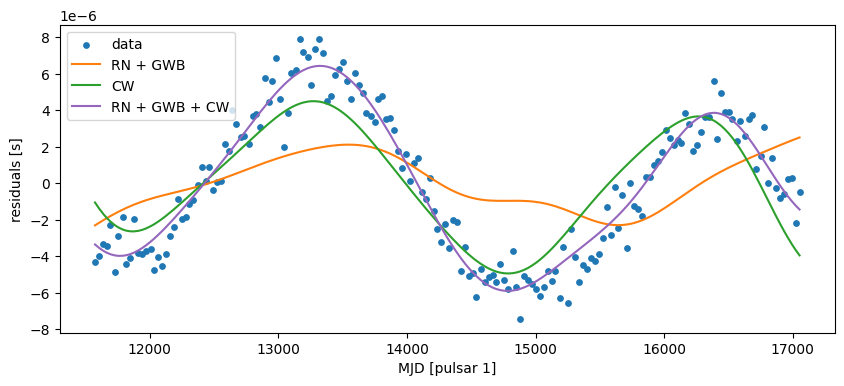

In [5]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
if pta.model_gwb or pta.model_rn:
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if pta.model_cw:
    cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (pta.model_gwb or pta.model_rn) and pta.model_cw:
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [6]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[pta.efac_ndxs]
    rn_hypers = x[pta.rn_ndxs]
    gwb_hypers = x[pta.gwb_ndxs]
    cw_psr_params = x[pta.cw_psr_ndxs]
    psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn_gwb(rn_hypers, gwb_hypers, a)
    lnprior_val += l.psr_dist_lnprior(psr_dists)
    # lnprior_val += l.a_lnprior_rn(rn_hypers, a)
    # lnprior_val += l.a_lnprior_rn_gwb_free_spectral(rn_hypers, gwb_hypers, a)

    # likelihood
    a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike(pta.efacs_inj, a + a_cw)

    return lnprior_val + lnlike_val


vectorized_lnpost = jit(vmap(lnpost))

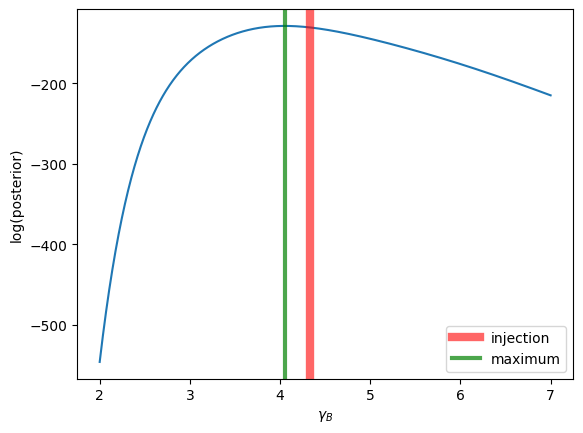

In [9]:
# plot cross-section of posterior
param_ndx = 16
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [10]:
@jit
def transform_a(rn_hypers, gwb_hypers, a_standard):
    rn_phi = jnp.zeros((pta.Na, pta.Np, pta.Np))
    rn_phi = rn_phi.at[:, jnp.arange(pta.Np), jnp.arange(pta.Np)].set(pta.vectorized_get_rho_diag(rn_hypers.reshape((pta.Np, 2))).T)
    gwb_phi = pta.get_rho_diag(gwb_hypers)[:, None, None] * pta.alpha[None, :, :]
    # gwb_phi = jnp.repeat(10. ** gwb_hypers, 2)[:, None, None] * pta.alpha[None, :, :]
    phi = rn_phi + gwb_phi
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((pta.Np, pta.Na)).T).T.flatten()
    return a_transformed

In [11]:
def sampling_model():
    # uniform prior on hyper-parameters
    efacs = numpyro.sample('efacs', dist.Uniform(pta.efac_mins, pta.efac_maxs))
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.rn_mins, pta.rn_maxs))
    gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))

    # uniform prior on CW parameters and pulsar phases
    cw_params = numpyro.sample('cw', dist.Uniform(pta.cw_mins, pta.cw_maxs))
    psr_phases = numpyro.sample('psr_phases', dist.Uniform(pta.psr_phase_mins, pta.psr_phase_maxs))

    # normal prior on pulsar distances
    psr_dists = numpyro.sample('psr_dists', dist.Normal(pta.psr_dists_inj, pta.psr_dists_stdev))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na_PTA]))
    a_transformed = transform_a(rn_hypers, gwb_hypers, a_standard)
    a = numpyro.deterministic('a', a_transformed)

    # get CW coefficients
    a_cw = pta.get_CW_coefficients(jnp.concatenate((cw_params, psr_phases, psr_dists))).flatten()

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(efacs, a + a_cw))
    # numpyro.factor('ln_likelihood', l.lnlike(pta.efacs_inj, a))

In [12]:
# injected parameters in dictionary
x_inj_dict = {'efacs':pta.efacs_inj, 'rn_hypers':pta.rn_inj, 'gwb_hypers':pta.gwb_inj,
              'cw':pta.cw_inj, 'psr_phases':pta.psr_phases_inj, 'psr_dists':pta.psr_dists_inj,
              'a_standard':jnp.zeros(pta.Na_PTA)}
# x_inj_dict = {'rn_hypers':pta.rn_inj, 'gwb_hypers':pta.gwb_inj, 'a_standard':jnp.ones(pta.Na_PTA)}

In [23]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 # init_strategy=init_to_value(values=x_inj_dict),
                                 dense_mass=[('rn_hypers', 'gwb_hypers', 'a_standard'), ('cw',)],
                                 # dense_mass=False,
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e5))
mcmc.run(jr.key(22))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 110000/110000 [1:11:32<00:00, 25.63it/s, 1023 steps of size 5.50e-03. acc. prob=0.85]


In [24]:
# make samples object for post-processing
samples_arr = np.concatenate((samples_dict['efacs'],
                              samples_dict['rn_hypers'],
                              samples_dict['gwb_hypers'],
                              samples_dict['cw'],
                              samples_dict['psr_phases'],
                              samples_dict['psr_dists'],
                              samples_dict['a'],
                              ), axis=1)

samples = Samples(samples_arr=samples_arr,
                  labels=pta.x_labels,
                  x_inj=pta.x_inj,
                  lnpost_func=lnpost,
                  jax=True)

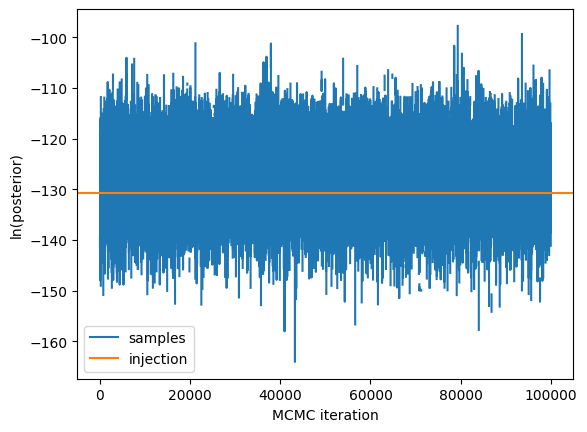

In [25]:
samples.plt_posterior_vals(legend=True)

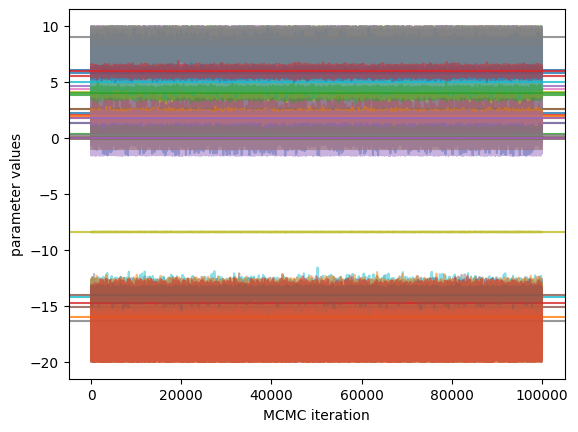

In [26]:
samples.trace_plt()

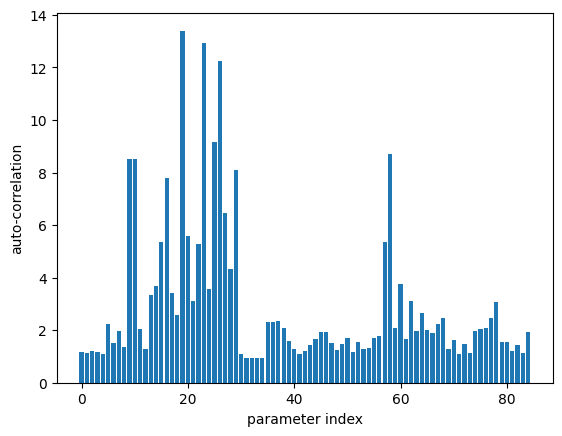

In [27]:
samples.plt_auto_corr()

Parameter $\log_{10}(D_{L}\,\,[\text{Mpc}])$ in chain samples is not constrained


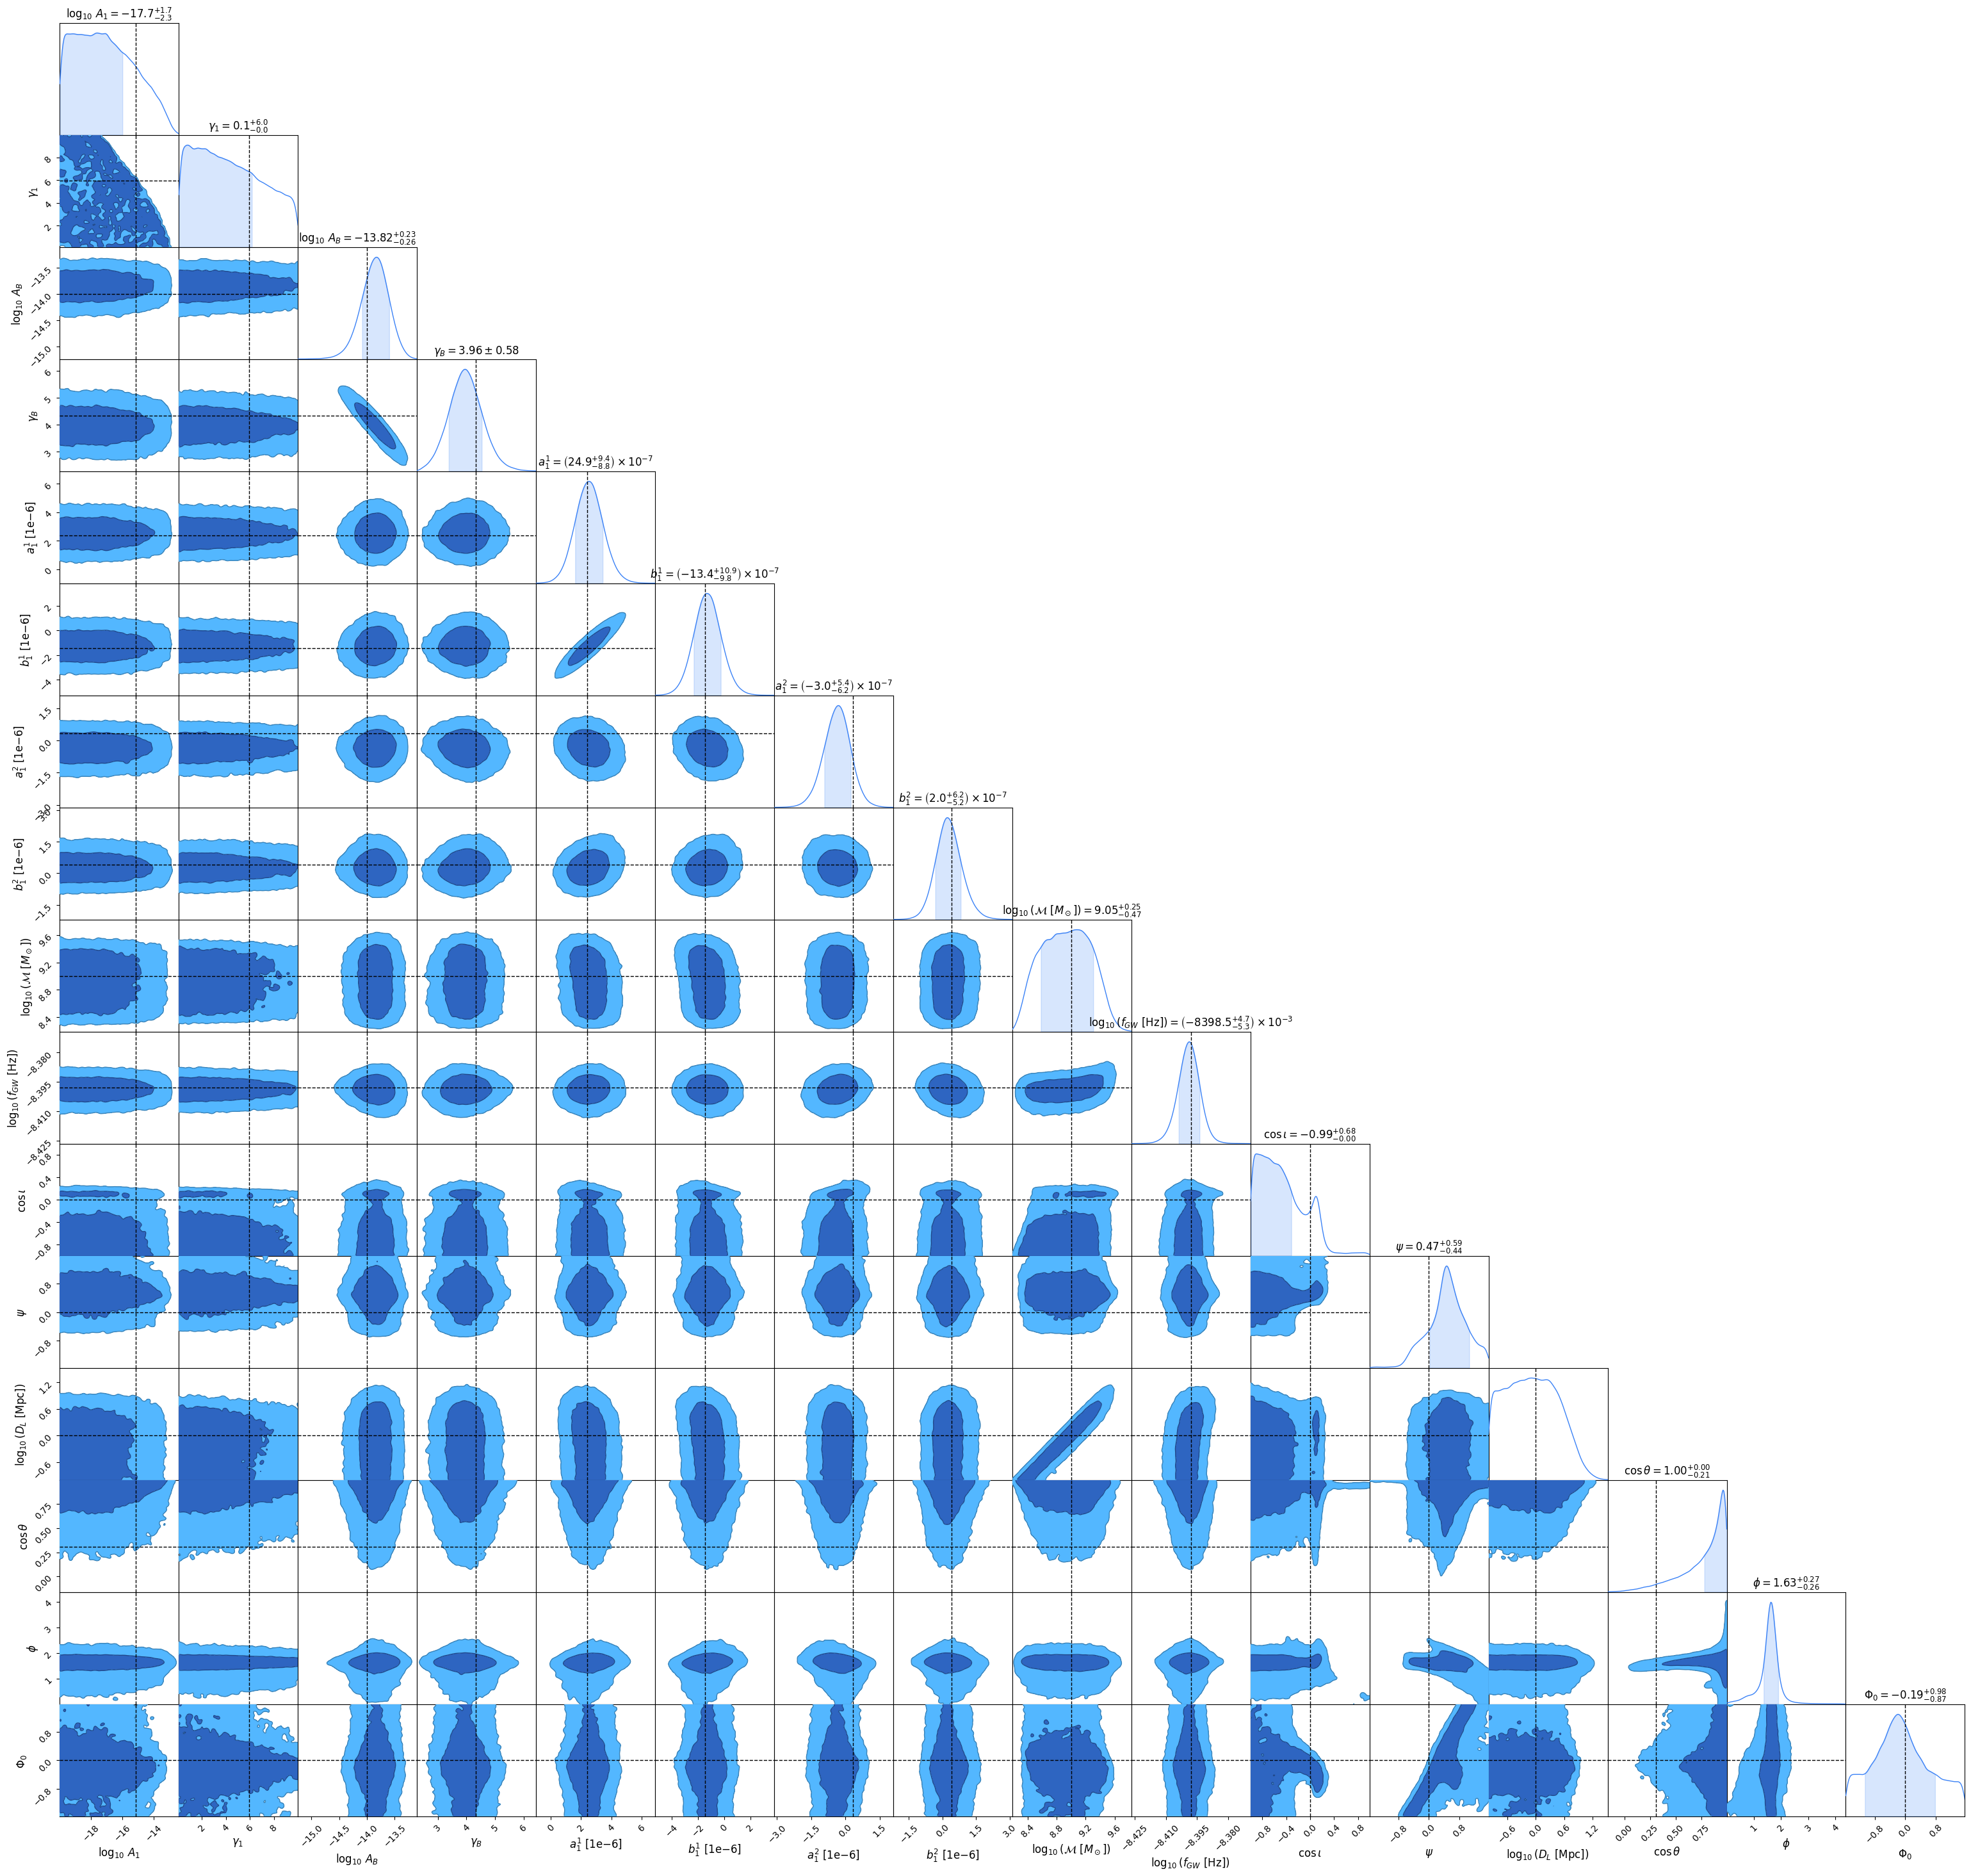

In [38]:
# indices of parameters to use in corner plot
psr_ndx = 0
rn_ndxs = pta.rn_ndxs.reshape((pta.Np, 2))[psr_ndx]
a_ndxs = pta.a_ndxs.reshape((pta.Np, pta.Na))[psr_ndx]
ndxs = np.concatenate((rn_ndxs,
                       pta.gwb_ndxs,
                       a_ndxs[:4],
                       pta.cw_ndxs))
samples.corner_plt(param_ndxs=ndxs)

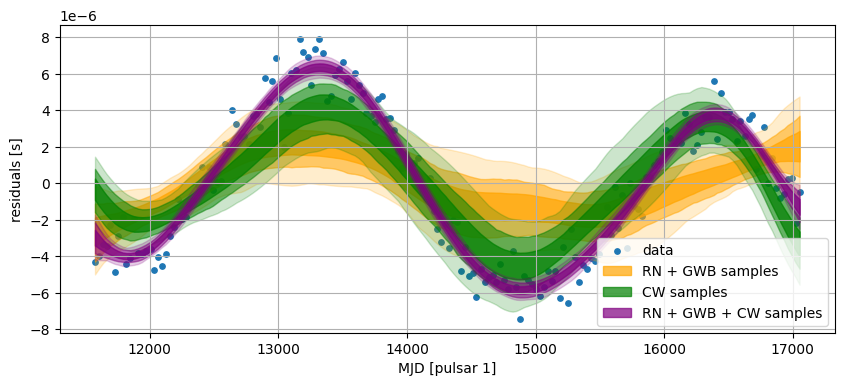

In [32]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (1000,))

# percentile layers for plotting densities of samples
percentile_layers = [0.15, 2.5, 16.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

# Bayesogram for RN + GWB
if pta.model_rn or pta.model_gwb:
    rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples_arr[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                               for ndx in fair_draw_ndxs])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha, label='RN + GWB samples')
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    # plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='orange', label='RN + GWB injection')

# Bayesogram for CW
if pta.model_cw:
    a_cws = np.array([pta.get_CW_coefficients(samples_arr[ndx, pta.cw_psr_ndxs])[psr_ndx]
                  for ndx in fair_draw_ndxs])
    cw_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ a_cw for a_cw in a_cws])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha, label='CW samples')
    cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    # plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ cw_residuals_inj, color='green', label='CW injection')

# Bayesogram for RN + GWB + CW
if pta.model_rn and pta.model_gwb and pta.model_cw:
    signals = cw_signals + rn_gwb_signals
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha, label='RN + GWB + CW samples')
    # plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='purple', label='RN + GWB + CW injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()